In [1]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import time

from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [2]:
# initialize logging
eval_log_path = Path('../logs/result_log')
if not os.path.exists(eval_log_path):
    os.mkdir(eval_log_path)

In [3]:
# -- ARCHIVED --
# upload / download models and logs to tensorboard

# copy relevant model metrics into seperate folder and upload to tensorboard dev
# data_filter = 'test' # 'train', 'test' or 'validation'
# model_filter = 'resnet'# 'basic' or 'resnet'
# log_path = '../logs/scalars'
# upload_path = '../tensorboard_upload/'
# os.mkdir(upload_path)

# for (dirpath, dirnames, filenames) in os.walk(log_path):
#     # filter dirs
#     if data_filter in dirpath and model_filter in dirpath:

#         from_directory = dirpath
#         to_directory = upload_path + dirpath[16:]

#         # copy dir trees
#         shutil.copytree(from_directory, to_directory)

# # TODO: run in project root for upload
# print(f'tensorboard dev upload --logdir=./tensorboard_upload/ --name FLE_{model_filter}_{data_filter}')

# # remove copied dir trees
# shutil.rmtree(upload_path)

# # TODO: set tensorboard dev ID
# experiment_ids = ['0m4NvD5jTxmSw3hr8SeJww', 'uLYWP18zQ1eMtDBiLHLHrg'] # [resnet, basic]
# all_dfs = []

# # download experiments
# for ind, id in enumerate(experiment_ids):
#     experiment = tb.data.experimental.ExperimentFromDev(id)
#     df_temp = experiment.get_scalars()
    
#     print(f'{ind}: {df_temp.shape}')
#     all_dfs.append(df_temp)

# # combine experiments into single dataframe
# df = all_dfs[0]

# if len(all_dfs) > 1:
#     for new_df in all_dfs[1:]:
#         df = pd.concat([df, new_df])

# print(df.shape)
# df.head()

In [5]:
# define path and file filter
report_log_path = '../logs/class_report'
filter = 'class_report_19epoch.json'

# define metrics to be extracted as list
logs = [['accuracy']
        , ['macro avg', 'precision']
        , ['macro avg', 'recall']
        , ['macro avg', 'f1-score']
        , ['weighted avg', 'precision']
        , ['weighted avg', 'recall']
        , ['weighted avg', 'f1-score']
]

# init dataframe
df_headers = ['run', 'model', 'ratio', 'classes', 'metric', 'value']
df = pd.DataFrame(columns=df_headers)

# iter through logs and get metrics from classification report jsons
counter = 0
for (dirpath, dirnames, filenames) in os.walk(report_log_path):

    if filter in filenames:
        counter += 1

        file_path = dirpath+'/'+filter
        class_report = json.load(open(file_path))

        for log in logs:

            run = dirpath.split('\\', 1)[-1].replace('\\', '_')
            model = re.search('(^[a-z]{5,6})_', run).group(1)
            ratio = float(re.search('(\d{5})r', run).group(1)) / 100
            classes = re.search('(\d{1,2})c', run).group(1)
            
            if len(log) == 1:
                metric = log[0]
                value = class_report[log[0]]
            elif len(log) == 2:
                metric = log[0] + ' ' + log[1]
                value = class_report[log[0]][log[1]]
            
            row = [
                str(run),
                str(model),
                float(ratio),
                str(classes),
                str(metric),
                float(value)
            ]

            df_len = len(df)
            df.loc[df_len] = row

print(f'{counter} classification reports found - df.shape {df.shape}')
df.head()

800 classification reports found - df.shape (5600, 6)


,run,model,ratio,classes,metric,value
0,basic_00000r_14c_20220413-1643,basic,0.0,14,accuracy,0.844503
1,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg precision,0.818496
2,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg recall,0.805868
3,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg f1-score,0.807963
4,basic_00000r_14c_20220413-1643,basic,0.0,14,weighted avg precision,0.853091


In [31]:
df['metric'].unique()

array(['accuracy', 'macro avg precision', 'macro avg recall',
       'macro avg f1-score', 'weighted avg precision',
       'weighted avg recall', 'weighted avg f1-score'], dtype=object)

In [32]:
# check wich training setups have less than 20 runs
df_runs = df.groupby(['model', 'ratio', 'classes', 'metric']).count().reset_index()
df_runs = df_runs.drop('value', axis=1).query('metric == "accuracy"')
df_runs.query('run < 20').sort_values(by=['model', 'ratio', 'classes'], axis=0)

,model,ratio,classes,metric,run


--------------

## regression

In [52]:
# TODO: set regression data parameters
regressand = 'accuracy' # regressand to use
cnn = None # model to filter for ('resnet', 'basic'), use None for all
classes = None # classification task to filter for (4 or 14), use None for all

use_delta = False # use regressand delta to 0 ratio model for regression
use_aggr = True # use aggregated data for each model + classes + ratio + metric

# TODO: set data preparation parameters
use_scaling = False # use scaling for regression
zscore_threshold = 3 # zscore threshold for removing outlier based on regressand

# file name depending on regression data parameters
file_name = '_regr_params.json'
if use_delta: file_name = '_delta' + file_name
file_name = regressand + file_name
if cnn: file_name = cnn + 'CNN_' + file_name
if classes: file_name = str(classes) + 'classes_' + file_name

file_name = file_name.replace(' ', '_')

In [53]:
# preprocess dataframe
df_regression = df.query(f'metric == "{regressand}"')
df_regression.drop(['run'], axis=1, inplace=True)
df_regression = df_regression.rename(columns={'value': regressand})

if cnn:
    df_regression = df_regression.query(f'model == "{cnn}"')
if classes:
    df_regression = df_regression.query(f'classes == "{classes}"')

if use_aggr:
    df_regression = df_regression.groupby(['model', 'ratio', 'classes', 'metric']).mean().reset_index()

df_tmp = df.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
df_regression[f'{regressand}_delta'] = df_regression.apply(lambda row:
    row[regressand] - df_tmp.query(f'model=="{row.model}" & classes=="{row.classes}" & ratio==0.0 & metric=="{row.metric}"').iloc[0]['value'], axis=1
)

df_regression.drop(['metric'], axis=1, inplace=True)

df_regression.reset_index(inplace=True, drop=True)
print(df_regression.shape)
df_regression.head()

KeyError: "['run'] not found in axis"

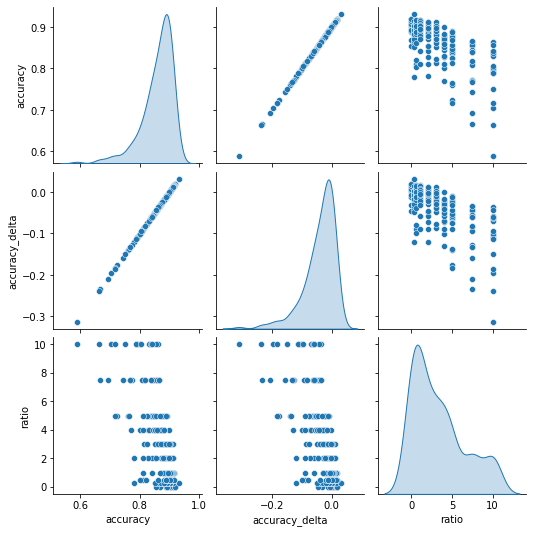

In [35]:
# sns.pairplot(df_regression[[regressand, f'{regressand}_delta', 'ratio']], diag_kind='kde')

<AxesSubplot:xlabel='ratio', ylabel='accuracy'>

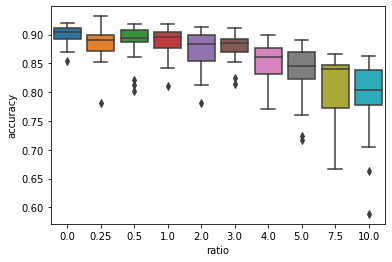

In [36]:
# sns.boxplot(x='ratio', y=regressand, data=df_regression)

In [48]:
# filter outlier of regressand (if data is not aggregated)
if not use_aggr:
    # create mask based on zscore threshold
    mask = np.abs(stats.zscore(df_regression[regressand])) > zscore_threshold
    print(f'{mask.sum()} rows filtered')

    # apply mask
    df_regression[regressand] = df_regression[regressand].mask(mask)

    # drop outliers
    df_regression.dropna(inplace=True)

4 rows filtered


In [38]:
df_regression.describe()

,ratio,accuracy,accuracy_delta
count,196.000000,196.000000,196.000000
mean,3.214286,0.863359,-0.037281
std,3.116334,0.045092,0.045092
min,0.000000,0.704443,-0.196197
25%,0.500000,0.840267,-0.060373
50%,2.000000,0.876318,-0.024322
75%,5.000000,0.896555,-0.004085
max,10.000000,0.931852,0.031212


In [39]:
# get independent and dependent variables
if use_delta:
    X_df = df_regression[[f'{regressand}_delta']]
else:
    X_df = df_regression[[regressand]]
y_df = df_regression['ratio']

for column in X_df.columns:
    r, p = stats.pearsonr(X_df[column], y_df)
    print(f'{round(r, 4)} pearsonr, {p} p-value, Variable: {column}')

# split data
X_train, X_test, y_train, y_test = train_test_split(
                                                X_df
                                                , y_df
                                                , test_size=0.15
                                                , stratify=y_df
                                            )

# scale X data
if use_scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

print(f'\nX_train.shape {X_train.shape} - y_train.shape {y_train.shape}\n\
X_test.shape {X_test.shape} - y_test.shape {y_test.shape}')

y_train.value_counts()

-0.6349 pearsonr, 1.6341179014471866e-23 p-value, Variable: accuracy

X_train.shape (166, 1) - y_train.shape (166,)
X_test.shape (30, 1) - y_test.shape (30,)


2.00     17
3.00     17
5.00     17
0.50     17
4.00     17
0.00     17
1.00     17
0.25     17
10.00    15
7.50     15
Name: ratio, dtype: int64

In [40]:
# initialize estimators and hyperparameter params for each estimator
regr_dummy = DummyRegressor()
regr_dummy_params = {}
regr_dummy_params['strategy'] = ['mean', 'median', 'quantile']
regr_dummy_params['quantile'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

regr_linear = LinearRegression()
regr_linear_params = {}

regr_lasso = Lasso()
regr_lasso_params = {}
regr_lasso_params['max_iter'] = [10000]
regr_lasso_params['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_lasso_params['selection'] = ['random', 'cyclic']

regr_elastic = ElasticNet()
regr_elastic_params = {}
regr_elastic_params['max_iter'] = [10000]
regr_elastic_params['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_elastic_params['l1_ratio'] = np.linspace(0.001, 0.999, 10)
regr_elastic_params['selection'] = ['random', 'cyclic']

regr_ridge = Ridge()
regr_ridge_params = {}
regr_ridge_params['max_iter'] = [10000]
regr_ridge_params['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_ridge_params['solver'] = [
    'auto', 'svd', 'cholesky', 'lsqr'
    , 'sparse_cg', 'sag', 'saga'
]

regr_svr = SVR()
regr_svr_params = {}
regr_svr_params['kernel'] = ['linear', 'poly', 'rbf'] # 'sigmoid'
regr_svr_params['degree'] = [1, 2, 3]
regr_svr_params['gamma'] = [1e-1, 1.0, 10.0]
regr_svr_params['coef0'] = [0.0, 0.1, 0.3, 0.8]
regr_svr_params['C'] = [1e-1, 1.0, 10.0]
# regr_svr_params['epsilon'] = [1e-2, 1e-1, 1.0]

regr_randomForest = RandomForestRegressor()
regr_randomForest_params = {}
regr_randomForest_params['n_estimators'] = [100, 200, 300, 400, 500]
regr_randomForest_params['criterion'] = ['squared_error'] # 'absolute_error', 'poisson'
regr_randomForest_params['max_depth'] = [1, 2, 3, 4, 5]

regr_gradientBoost = GradientBoostingRegressor()
regr_gradientBoost_params = {}
regr_gradientBoost_params['loss'] = ['squared_error', 'huber']
regr_gradientBoost_params['learning_rate'] = [0.1, 0.2, 0.5, 0.7]
regr_gradientBoost_params['n_estimators'] = [100, 200, 400]
# regr_gradientBoost_params['criterion'] = ['friedman_mse', 'squared_error', 'absolute_error']
regr_gradientBoost_params['max_depth'] = [1, 2, 4]
regr_gradientBoost_params['alpha'] = [0.1, 0.5, 0.9]
regr_gradientBoost_params['warm_start'] = [True, False]

models_and_params = [
    [regr_dummy, regr_dummy_params]
    , [regr_linear, regr_linear_params]
    , [regr_lasso, regr_lasso_params]
    , [regr_elastic, regr_elastic_params]
    , [regr_ridge, regr_ridge_params]
    , [regr_svr, regr_svr_params]
    , [regr_randomForest, regr_randomForest_params]
    , [regr_gradientBoost, regr_gradientBoost_params]
]

In [41]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# iterate over models and hyperparameters and train
best_params_per_model = {}
for model, params in models_and_params:
    model_name = f'{str(model)[:-2]}'

    # run gridsearch
    print('--------')
    start = time.time()

    gs = GridSearchCV(
        model
        , params
        # , n_iter=2
        , n_jobs=-1
        , cv=5
        , scoring='r2'
        , verbose=1
    )
    gs.fit(X_train, y_train)

    end = time.time()
    print(
        f'{model_name}'\
        f' - Training time elapsed: {round((end - start) / 60, 3)} min'\
        f' - Best score: {round(gs.best_score_, 3)}'
    )

    # add best params + score per model to dict
    best_params_per_model[model_name] = {
        'score': gs.best_score_,
        'best_params': gs.best_params_
    }

# save best params per model
with open(f'{eval_log_path}/{file_name}', 'w') as f:
    json.dump(best_params_per_model, f)

--------
Fitting 5 folds for each of 27 candidates, totalling 135 fits
DummyRegressor - Training time elapsed: 0.137 min - Best score: -0.037
--------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
LinearRegression - Training time elapsed: 0.003 min - Best score: 0.351
--------
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Lasso - Training time elapsed: 0.004 min - Best score: 0.355
--------
Fitting 5 folds for each of 160 candidates, totalling 800 fits
ElasticNet - Training time elapsed: 0.021 min - Best score: 0.359
--------
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Ridge - Training time elapsed: 0.01 min - Best score: 0.358
--------
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
SVR - Training time elapsed: 2.076 min - Best score: 0.386
--------
Fitting 5 folds for each of 25 candidates, totalling 125 fits
RandomForestRegressor - Training time elapsed: 0.903 min - Best score: 0.436
--------
Fitting 5 folds for each of 4

In [44]:
# read models with best params
with open(f'{eval_log_path}/{file_name}', 'r') as f:
    regression_results = json.load(f)

# get best score / model
best_model = ''
best_train_score = 0

print('Scores:')
for model, results in regression_results.items():
    score = results["score"]
    print(f'{round(score,6)} - {model}')

    if score > best_train_score:
        best_train_score = score
        best_model = model
        best_params = results['best_params']
    
print(f'--------\nBest model: {best_model}\n    {round(best_train_score, 5)} - training score')

# transform params for scoring on test data
best_params_transform = {}
for key, value in best_params.items():
    best_params_transform[key] = value

# score best model on test data
models = {
    'DummyRegressor': regr_dummy,
    'LinearRegression': regr_linear,
    'Lasso': regr_lasso,
    'ElasticNet': regr_elastic,
    'Ridge': regr_ridge,
    'SVR': regr_svr,
    'RandomForestRegressor': regr_randomForest,
    'GradientBoostingRegressor': regr_gradientBoost
}

reg = models[best_model].set_params(**best_params_transform)
reg.fit(X_train, y_train)
test_score = reg.score(X_test, y_test)
print(f'    {round(test_score, 5)} - test score')

Scores:
-0.036618 - DummyRegressor
0.351161 - LinearRegression
0.355408 - Lasso
0.35872 - ElasticNet
0.357937 - Ridge
0.386223 - SVR
0.436165 - RandomForestRegressor
0.459995 - GradientBoostingRegressor
--------
Best model: GradientBoostingRegressor
    0.46 - training score
    0.29444 - test score
